In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

cities = pd.read_csv(f'./livingwage.csv') # you might need to change this path
cities = cities.dropna()
cities.head()

,rank_2020,city,state,population_2020,population_2010,land_area_sqmi,density,one_adult_no_kids_living_wage,one_adult_one_kid_living_wage,one_adult_two_kids_living_wage,one_adult_three_kids_living_wage,two_adults_one_working_no_kids_living_wage,two_adults_one_working_one_kid_living_wage,two_adults_one_working_two_kids_living_wage,two_adults_one_working_three_kids_living_wage,two_adults_both_working_no_kids_living_wage,two_adults_both_working_one_kid_living_wage,two_adults_both_working_two_kids_living_wage,two_adults_both_working_three_kids_living_wage
0,1,New York,New York,8804190,8175133,300.5,29298,20.00,38.99,49.18,64.30,29.16,34.35,38.13,42.42,14.03,20.95,26.53,32.40
1,2,Los Angeles,California,3898747,3792621,469.5,8304,19.22,41.55,51.30,67.56,31.01,37.96,41.94,47.75,14.62,22.36,27.73,34.01
2,3,Chicago,Illinois,2746388,2695598,227.7,12061,16.08,32.25,40.20,51.69,25.41,29.73,33.38,35.93,12.28,17.52,22.01,25.94
3,4,Houston,Texas,2304580,2099451,640.4,3599,14.29,29.09,35.73,46.02,22.88,27.54,30.93,33.69,11.14,15.85,19.63,23.09
4,5,Phoenix,Arizona,1608139,1445632,518.0,3105,15.41,29.44,35.40,46.01,24.85,29.25,32.98,36.95,12.03,16.21,19.65,23.23


In [2]:
salaries = pd.read_csv(f'./cp_major_sal (1).csv') # you might need to change this path
salaries = salaries.dropna()
salaries.head()

,Field of Study,Employment Rate,Median Debt,Median Salary,Salary Score,Degree Type
0,"Aerospace, Aeronautical and Astronautical Engi...",95%,"$22,410","$76,020",98,B
1,Agricultural Business and Management,97%,"$18,390","$56,190",96,B
2,Agricultural Engineering,100%,"$20,000","$63,010",85,B
3,Agricultural Public Services,100%,Not Reported,"$41,300",72,B
4,"Agriculture, General",96%,"$13,000","$49,640",97,B


In [3]:
# Assuming work 40 hours a week, 52 weeks a year for the conversion (which is a massive over-simplification but I think the best we can do to approximate)
import locale
locale.setlocale(locale.LC_ALL,'')
salaries['med-hourly'] = salaries['Median Salary'].replace('[\$,]', '', regex=True).astype(float)
salaries['med-hourly'] = salaries['med-hourly'] / (40 * 52)
# Remove the higher than bachelors
salaries = salaries[salaries['Degree Type'] == 'B']
salaries.columns = ['field-study', 'employment-rate', 'med-debt', 'med-salary', 'salary-score', 'degree-type', 'med-hourly']
salaries.head()

,field-study,employment-rate,med-debt,med-salary,salary-score,degree-type,med-hourly
0,"Aerospace, Aeronautical and Astronautical Engi...",95%,"$22,410","$76,020",98,B,36.548077
1,Agricultural Business and Management,97%,"$18,390","$56,190",96,B,27.014423
2,Agricultural Engineering,100%,"$20,000","$63,010",85,B,30.293269
3,Agricultural Public Services,100%,Not Reported,"$41,300",72,B,19.855769
4,"Agriculture, General",96%,"$13,000","$49,640",97,B,23.865385


What I'd like to do is do a join based on a major's salary being greater than the living wage (basically matching each major to a city they can live in)

In [4]:
cities.dtypes

rank_2020                                           int64
city                                               object
state                                              object
population_2020                                     int64
population_2010                                     int64
land_area_sqmi                                    float64
density                                             int64
one_adult_no_kids_living_wage                     float64
one_adult_one_kid_living_wage                     float64
one_adult_two_kids_living_wage                    float64
one_adult_three_kids_living_wage                  float64
two_adults_one_working_no_kids_living_wage        float64
two_adults_one_working_one_kid_living_wage        float64
two_adults_one_working_two_kids_living_wage       float64
two_adults_one_working_three_kids_living_wage     float64
two_adults_both_working_no_kids_living_wage       float64
two_adults_both_working_one_kid_living_wage       float64
two_adults_bot

In [5]:
salaries.dtypes

field-study         object
employment-rate     object
med-debt            object
med-salary          object
salary-score        object
degree-type         object
med-hourly         float64
dtype: object

In [6]:
combo = cities.merge(salaries[['field-study', 'med-hourly']], how='cross')
combo = combo[combo['one_adult_no_kids_living_wage'] < combo['med-hourly']]
combo.head()

,rank_2020,city,state,population_2020,population_2010,land_area_sqmi,density,one_adult_no_kids_living_wage,one_adult_one_kid_living_wage,one_adult_two_kids_living_wage,...,two_adults_one_working_no_kids_living_wage,two_adults_one_working_one_kid_living_wage,two_adults_one_working_two_kids_living_wage,two_adults_one_working_three_kids_living_wage,two_adults_both_working_no_kids_living_wage,two_adults_both_working_one_kid_living_wage,two_adults_both_working_two_kids_living_wage,two_adults_both_working_three_kids_living_wage,field-study,med-hourly
0,1,New York,New York,8804190,8175133,300.5,29298,20.0,38.99,49.18,...,29.16,34.35,38.13,42.42,14.03,20.95,26.53,32.4,"Aerospace, Aeronautical and Astronautical Engi...",36.548077
1,1,New York,New York,8804190,8175133,300.5,29298,20.0,38.99,49.18,...,29.16,34.35,38.13,42.42,14.03,20.95,26.53,32.4,Agricultural Business and Management,27.014423
2,1,New York,New York,8804190,8175133,300.5,29298,20.0,38.99,49.18,...,29.16,34.35,38.13,42.42,14.03,20.95,26.53,32.4,Agricultural Engineering,30.293269
4,1,New York,New York,8804190,8175133,300.5,29298,20.0,38.99,49.18,...,29.16,34.35,38.13,42.42,14.03,20.95,26.53,32.4,"Agriculture, General",23.865385
6,1,New York,New York,8804190,8175133,300.5,29298,20.0,38.99,49.18,...,29.16,34.35,38.13,42.42,14.03,20.95,26.53,32.4,Architectural Engineering,32.365385


In [7]:
combo = combo.set_index(['city', 'state', 'field-study'])
combo.head()

rank_2020  \
city     state    field-study                                                     
New York New York Aerospace, Aeronautical and Astronautical Engin...          1   
                  Agricultural Business and Management                        1   
                  Agricultural Engineering                                    1   
                  Agriculture, General                                        1   
                  Architectural Engineering                                   1   

                                                                      population_2020  \
city     state    field-study                                                           
New York New York Aerospace, Aeronautical and Astronautical Engin...          8804190   
                  Agricultural Business and Management                        8804190   
                  Agricultural Engineering                                    8804190   
                  Agriculture, General                                        8804190   
                  Architectural Engineering                                   8804190   

                                                                      population_2010  \
city     state    field-study                                                           
New York New York Aerospace, Aeronautical and Astronautical Engin...          8175133   
                  Agricultural Business and Management                        8175133   
                  Agricultural Engineering                                    8175133   
                  Agriculture, General                                        8175133   
                  Architectural Engineering                                   8175133   

                                                                      land_area_sqmi  \
city     state    field-study                                                          
New York New York Aerospace, Aeronautical and Astronautical Engin...           300.5   
                  Agricultural Business and Management                         300.5   
                  Agricultural Engineering                                     300.5   
                  Agriculture, General                                         300.5   
                  Architectural Engineering                                    300.5   

                                                                      density  \
city     state    field-study                                                   
New York New York Aerospace, Aeronautical and Astronautical Engin...    29298   
                  Agricultural Business and Management                  29298   
                  Agricultural Engineering                              29298   
                  Agriculture, General                                  29298   
                  Architectural Engineering                             29298   

                                                                      one_adult_no_kids_living_wage  \
city     state    field-study                                                                         
New York New York Aerospace, Aeronautical and Astronautical Engin...                           20.0   
                  Agricultural Business and Management                                         20.0   
                  Agricultural Engineering                                                     20.0   
                  Agriculture, General                                                         20.0   
                  Architectural Engineering                                                    20.0   

                                                                      one_adult_one_kid_living_wage  \
city     state    field-study                                                                         
New York New York Aerospace, Aeronautical and Astronautical Engin...                          38.99   
                  Agricu

In [8]:
df = combo.drop(["rank_2020"], axis=1)
df.head()

population_2020  \
city     state    field-study                                                           
New York New York Aerospace, Aeronautical and Astronautical Engin...          8804190   
                  Agricultural Business and Management                        8804190   
                  Agricultural Engineering                                    8804190   
                  Agriculture, General                                        8804190   
                  Architectural Engineering                                   8804190   

                                                                      population_2010  \
city     state    field-study                                                           
New York New York Aerospace, Aeronautical and Astronautical Engin...          8175133   
                  Agricultural Business and Management                        8175133   
                  Agricultural Engineering                                    8175133   
                  Agriculture, General                                        8175133   
                  Architectural Engineering                                   8175133   

                                                                      land_area_sqmi  \
city     state    field-study                                                          
New York New York Aerospace, Aeronautical and Astronautical Engin...           300.5   
                  Agricultural Business and Management                         300.5   
                  Agricultural Engineering                                     300.5   
                  Agriculture, General                                         300.5   
                  Architectural Engineering                                    300.5   

                                                                      density  \
city     state    field-study                                                   
New York New York Aerospace, Aeronautical and Astronautical Engin...    29298   
                  Agricultural Business and Management                  29298   
                  Agricultural Engineering                              29298   
                  Agriculture, General                                  29298   
                  Architectural Engineering                             29298   

                                                                      one_adult_no_kids_living_wage  \
city     state    field-study                                                                         
New York New York Aerospace, Aeronautical and Astronautical Engin...                           20.0   
                  Agricultural Business and Management                                         20.0   
                  Agricultural Engineering                                                     20.0   
                  Agriculture, General                                                         20.0   
                  Architectural Engineering                                                    20.0   

                                                                      one_adult_one_kid_living_wage  \
city     state    field-study                                                                         
New York New York Aerospace, Aeronautical and Astronautical Engin...                          38.99   
                  Agricultural Business and Management                                        38.99   
                  Agricultural Engineering                                                    38.99   
                  Agriculture, General                                                        38.99   
                  Architectural Engineering                                                   38.99   

                                                                      one_adult_two_kids_living_wage  \
city     state    field-study                                                            

In [9]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(df),columns=df.columns)
X

,population_2020,population_2010,land_area_sqmi,density,one_adult_no_kids_living_wage,one_adult_one_kid_living_wage,one_adult_two_kids_living_wage,one_adult_three_kids_living_wage,two_adults_one_working_no_kids_living_wage,two_adults_one_working_one_kid_living_wage,two_adults_one_working_two_kids_living_wage,two_adults_one_working_three_kids_living_wage,two_adults_both_working_no_kids_living_wage,two_adults_both_working_one_kid_living_wage,two_adults_both_working_two_kids_living_wage,two_adults_both_working_three_kids_living_wage,med-hourly
0,9.551194,9.463002,0.540107,6.578376,1.974201,1.544227,1.640495,1.569891,1.443897,1.250600,1.244913,1.135258,1.382726,1.522014,1.617516,1.582803,1.158545
1,9.551194,9.463002,0.540107,6.578376,1.974201,1.544227,1.640495,1.569891,1.443897,1.250600,1.244913,1.135258,1.382726,1.522014,1.617516,1.582803,0.063122
2,9.551194,9.463002,0.540107,6.578376,1.974201,1.544227,1.640495,1.569891,1.443897,1.250600,1.244913,1.135258,1.382726,1.522014,1.617516,1.582803,0.439864
3,9.551194,9.463002,0.540107,6.578376,1.974201,1.544227,1.640495,1.569891,1.443897,1.250600,1.244913,1.135258,1.382726,1.522014,1.617516,1.582803,-0.298705
4,9.551194,9.463002,0.540107,6.578376,1.974201,1.544227,1.640495,1.569891,1.443897,1.250600,1.244913,1.135258,1.382726,1.522014,1.617516,1.582803,0.677951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4432,-0.455905,-0.452184,-0.586946,-0.181130,0.226301,-0.203164,-0.239486,-0.296797,-0.117707,-0.160329,-0.163692,-0.253284,0.037995,-0.210509,-0.243423,-0.308698,-1.104114
4433,-0.455905,-0.452184,-0.586946,-0.181130,0.226301,-0.203164,-0.239486,-0.296797,-0.117707,-0.160329,-0.163692,-0.253284,0.037995,-0.210509,-0.243423,-0.308698,-0.271084
4434,-0.455905,-0.452184,-0.586946,-0.181130,0.226301,-0.203164,-0.239486,-0.296797,-0.117707,-0.160329,-0.163692,-0.253284,0.037995,-0.210509,-0.243423,-0.308698,-0.925687
4435,-0.455905,-0.452184,-0.586946,-0.181130,0.226301,-0.203164,-0.239486,-0.296797,-0.117707,-0.160329,-0.163692,-0.253284,0.037995,-0.210509,-0.243423,-0.308698,-0.387090


,0,1
0,7.385485,13.848617
1,7.319265,13.849088
2,7.342039,13.848926
3,7.297391,13.849243
4,7.356432,13.848823
...,...,...
4432,-0.669725,-0.703501
4433,-0.619366,-0.703860
4434,-0.658938,-0.703578
4435,-0.626379,-0.703810


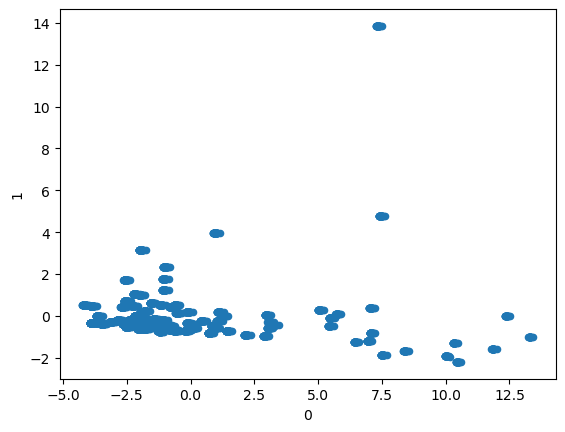

In [10]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca = pd.DataFrame(X_pca)
display(X_pca)
X_pca.plot.scatter(x=X_pca.columns[0],y=X_pca.columns[1]);

In [11]:
kmeans = KMeans(n_clusters=3).fit(X)

In [12]:
cluster_labels = {}
# Are we doing 1 indexing now?
cluster_labels[3] = kmeans.predict(X)
cluster_labels = pd.DataFrame(cluster_labels)

In [22]:
cluster_labels

,3
0,1
1,1
2,1
3,1
4,1
...,...
4432,2
4433,2
4434,2
4435,2


<AxesSubplot:xlabel='0', ylabel='1'>

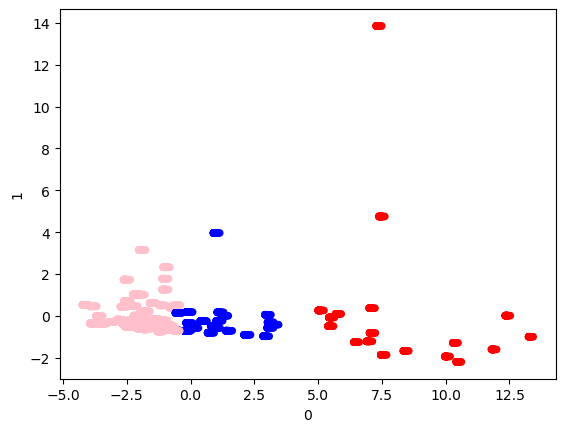

In [13]:
colorings = {}
# colorings[2] = cluster_labels[2].map({0: "Blue", 1: "Red"}) # This is a new pandas command for us that maps all 0 values to Blue, etc
colorings[3] = cluster_labels[3].map({0: "Blue", 1: "Red",2: "Pink"}) # This is a new pandas command for us that maps all 0 values to Blue, etc
# X_pca.plot.scatter(x=X_pca.columns[0],y=X_pca.columns[1],c=colorings[2])
X_pca.plot.scatter(x=X_pca.columns[0],y=X_pca.columns[1],c=colorings[3])

In [14]:
cluster_labels[3]

0       1
1       1
2       1
3       1
4       1
       ..
4432    2
4433    2
4434    2
4435    2
4436    2
Name: 3, Length: 4437, dtype: int32

In [23]:
combined_info = cities[['city', 'state']]
# combined_info['cluster'] = cluster_labels[3]
combined_info['PC1'] = X_pca[0]
combined_info['PC2'] = X_pca[1]
combined_info.head()

/tmp/ipykernel_9009/3495840646.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_info['PC1'] = X_pca[0]
/tmp/ipykernel_9009/3495840646.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_info['PC2'] = X_pca[1]


,city,state,PC1,PC2
0,New York,New York,7.385485,13.848617
1,Los Angeles,California,7.319265,13.849088
2,Chicago,Illinois,7.342039,13.848926
3,Houston,Texas,7.297391,13.849243
4,Phoenix,Arizona,7.356432,13.848823


In [23]:
# curious how some of our cities line up
# Yep, san diego expensive
# combined_info[combined_info['city'] == 'San Diego']
# combined_info[combined_info['city'] == 'Colorado Springs']
# # Not in the dataset
# combined_info[combined_info['city'] == 'San Luis Obispo']
# combined_info[combined_info['city'] == 'Seattle']

,city,state,cluster,PC1,PC2
17,Seattle,Washington,0,2.021802,0.074441


In [20]:
cluster_labels[3]

0       1
1       1
2       1
3       1
4       1
       ..
4432    2
4433    2
4434    2
4435    2
4436    2
Name: 3, Length: 4437, dtype: int32

In [24]:
df = combo.reset_index()[['city','state','field-study']]
df['label']  = cluster_labels[3]
df['label'].value_counts()

2    2878
0    1012
1     547
Name: label, dtype: int64

In [28]:
for cluster in df['label'].unique():
    print(cluster)
    # display(df[df['label'] == cluster].head())
    display(df[df['label'] == cluster].groupby(['state', 'city'])['label'].value_counts())

1


,city,state,field-study,label
0,New York,New York,"Aerospace, Aeronautical and Astronautical Engi...",1
1,New York,New York,Agricultural Business and Management,1
2,New York,New York,Agricultural Engineering,1
3,New York,New York,"Agriculture, General",1
4,New York,New York,Architectural Engineering,1


state                 city           label
California            Anaheim        1        35
                      Chula Vista    1        29
                      Fremont        1        27
                      Irvine         1        27
                      Long Beach     1        35
                      Los Angeles    1        35
                      Oakland        1        26
                      San Diego      1        34
                      San Francisco  1        26
                      San Jose       1        21
                      Santa Ana      1        27
                      Santa Clarita  1        35
District of Columbia  Washington     1        32
Hawaii                Honolulu       1        30
Massachusetts         Boston         1        35
New Jersey            Jersey City    1        31
                      Newark         1        31
New York              New York       1        31
Name: label, dtype: int64

0


,city,state,field-study,label
66,Chicago,Illinois,"Aerospace, Aeronautical and Astronautical Engi...",0
67,Chicago,Illinois,Agricultural Business and Management,0
68,Chicago,Illinois,Agricultural Engineering,0
69,Chicago,Illinois,Agricultural Public Services,0
70,Chicago,Illinois,"Agriculture, General",0


state           city              label
California      Bakersfield       0        50
                Fresno            0        50
                Riverside         0        45
                Sacramento        0        42
                Stockton          0        47
Colorado        Aurora            0        39
                Colorado Springs  0        48
                Denver            0        39
Florida         Miami             0        44
Georgia         Atlanta           0        42
Illinois        Chicago           0        42
Maryland        Baltimore         0        45
Michigan        Detroit           0        50
Minnesota       Minneapolis       0        45
                Saint Paul        0        45
North Carolina  Durham            0         2
                Raleigh           0        42
Oregon          Portland          0        36
Virginia        Chesapeake        0        42
                Norfolk           0        42
                Virginia Beach    0     

2


,city,state,field-study,label
108,Houston,Texas,"Aerospace, Aeronautical and Astronautical Engi...",2
109,Houston,Texas,Agricultural Business and Management,2
110,Houston,Texas,Agricultural Engineering,2
111,Houston,Texas,Agricultural Public Services,2
112,Houston,Texas,"Agriculture, General",2


state           city             label
Alaska          Anchorage        2        47
Arizona         Chandler         2        45
                Gilbert          2        45
                Glendale         2        45
                Mesa             2        46
                Phoenix          2        46
                Scottsdale       2        46
                Tucson           2        50
Florida         Jacksonville     2        51
                Orlando          2        46
                St. Petersburg   2        46
                Tampa            2        46
Idaho           Boise            2        50
Indiana         Fort Wayne       2        51
                Indianapolis     2        50
Kansas          Wichita          2        51
Kentucky        Lexington        2        50
                Louisville       2        50
Louisiana       Baton Rouge      2        50
                New Orleans      2        47
Missouri        Kansas City      2        50
                

Break majors by colleges (like the colleges within cal poly)
TODO: cluster df_degrees_over_career